# Part 4: Deploying as a Container Service

In the previous milestone we saw the benefits of going serverless versus executing our model locally: it's accessible from everywhere, and people can use it without worrying about dependencies or having the model files locally. However, we also saw some of the drawbacks: there are limitations on the size of your function, there's a max timeout that might be limiting for long-running models, and the first requests after not using it for a while will experience a cold start.

Fortunately, there’s another hosting solution: containers. Containers are a similar to virtual machines, but more lightweight: in essence, they give your application an isolated environment to run in, but can share hardware with other isolated containers, which allows them to be easily duplicated and scaled in a manner similar to FaaS, but with fewer restrictions

The goal of this milestone is to use containers to run our model, so we can directly compare the experience of both options. The steps are similar to what we did in the last milestone, but adapted to a container workflow.

## 1. Setting up Docker

In this milestone we will use Docker, the most widely-used container technology. 

### Setting up a simple web server
A difference between a Lambda function and a container is that Lambda offers an API to invoke functions out-of-the-box: you can use the `Test` option in the Console, use the `Invoke` operation of its API, or integrate it with other AWS services. With a container, however, you only have a running process: you are the one responsible for setting a way of interacting with that process.

In this case, we will set up a web server by using [Flask](https://flask.palletsprojects.com/en/2.0.x/), a web framework for Python

To start, we will forget about our model and set up a simple web server that renders plain text. This will let us ensure that we can get Flask up and running. First, create a file called `app.py` and add the following content:

In [ ]:
from flask import Flask
 
app = Flask(__name__)
 
 
@app.route('/')
def hello_world():
    return 'Hello world!'
 
if __name__ == '__main__':
    # You can try a different port if you are already using 5000
    # You can try with 4000, 6000 or 8000 for example
    app.run(debug=True, host='0.0.0.0', port=5000)

Then, create another one called `requirements.txt` and add this:

In [ ]:
Flask==2.0.2

And finally, create another one called `Dockerfile` and add this:

In [ ]:
FROM ubuntu:latest
RUN apt-get update -y
RUN apt-get install -y python3-pip python3-dev build-essential

COPY . /app
WORKDIR /app
RUN pip3 install -r requirements.txt
ENTRYPOINT ["python3"]
CMD ["app.py"]

Now, in the same directory where you have all the files, run the following command:

```
docker build -t m4-example:latest .
```

The goal of `docker build` is to process the content of your Dockerfile and execute the operations on it. It's kind of like running the installation steps of your own container.

Now, we will execute `docker run` to start an instance of the container we just created. If the previous command was equivalent to the installation steps, this is like opening what you just installed

```
docker run -p 5000:5000 m4-example
```

Now, if you go to `http://localhost:5000` on any web browser, you should see something like this:

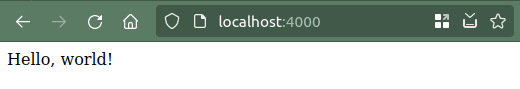

This means that the Docker container is up and running in your machine! Great work!

Now, stop the running container. You can either use `Ctrl+C` in your terminal, or `docker stop` and the container name or ID (which you can get with `docker ps`).

### Using docker-compose
Now we're going to run our container using `docker-compose` instead. 

`docker-compose` is a tool for defining and running multi-container Docker applications. With it, you use a YAML file to configure your application’s services. Then, with a single command, you create and start all the services from your configuration.

While we won't need to run multiple containers in our application, it's a good practice to become familiar with it in case you need it for production projects (for example, you might need to run a database where some data is stored, or a cache to avoid recomputing recent queries).

To start, create a new folder called `web` and move there the files we created previously (`app.py`, `requirements.txt` and `Dockerfile`). Now, in the original folder (not `web`) create a file called `docker-compose.yml` with the following content:

```yml
web:
  build: ./web
  ports:
   # If you didn't use port 5000 in app.py, change it here too
   - "5000:5000"
  volumes:
   - .:/code
```

Now, let's verify the result. Run:

```
docker-compose up --build
```

And go to `http://localhost:5000` again. If you see the same text as before, it's a success!

## 2. Verifying our model

At this point, we are already familiar with Docker and Docker Compose. The next step is to integrate our model with the containers.

### Preparing our model

Like we did in Milestone 3, we need to ensure that we have a version of our model that we can run in the desired environment (in this case, a Docker container). We will need the following changes:

**1) Update `requirements.txt`**
Modify the `requirements.txt` file to add all the dependencies that your model uses.

A simple way to do so can be by adding Flask to a `requirements.txt` from the previous milestone, if you have one


**2) Add the file that will use the model**

Create a `main.py` file in the `web` folder and fill it with the code that you need to run predictions on the model. You can use the one from the previous milestone and remove the parts related with Lambda. The resulting code should be something similar to this one, but changing the lemmatizer and the `extract_features` to match the ones in your own model.

In [ ]:
import json
import pickle
import re
from string import punctuation

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.util import everygrams

nltk.download("punkt")
nltk.download("stopwords")
nltk.download('wordnet')

model_file = open('sa_classifier.pickle', 'rb')                                                                                                                                                                
model = pickle.load(model_file)

stopwords_eng = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def bag_of_words(words):                                                                                                                                                                                       
    bag = {}                                                                                                                                                                                                   
    for w in words:                                                                                                                                                                                            
        bag[w] = bag.get(w,0)+1                                                                                                                                                                                
    return bag

def is_useful_word(word):
    return (word not in stopwords_eng) and (word not in punctuation)

def extract_features(document):
    words = word_tokenize(document)
    lemmas = [str(lemmatizer.lemmatize(w)) for w in words if is_useful_word(w)]
    document = " ".join(lemmas)
    document = document.lower()
    document = re.sub(r'[^a-zA-Z0-9\s]', ' ', document)
    words = [w for w in document.split(" ") if w != "" and is_useful_word(w)]
    return [str('_'.join(ngram)) for ngram in list(everygrams(words, max_len=3))]

def get_sentiment(review):
    words = extract_features(review)
    words = bag_of_words(words)
    return model.classify(words)


### Serving our predictions on a web server
Now that our model is ready, we need to modify our Flask web server to add a new endpoint that we can use to predict sentiment.

Let's make the following assumptions about our endpoint:

- We will call it `/predict`
- We will receive the text in a field called `input`
- We will accept requests both using an HTTP GET (with the input specified via query params) or using an HTTP POST (with the input specified via JSON payload).

Considering all this, we will create a new endpoint and add it to the `app.py` file

The resulting code should look like this:

In [ ]:
from flask import Flask, request
# Don't forget to add this import too!
from main import get_sentiment

app = Flask(__name__)


# Note: this route is not required anymore, but you can
# keep it as an easy way to test that your container is
# up and running correctly
@app.route('/')
def hello_world():
    return 'Hello world!'

@app.route('/predict', methods = ['GET', 'POST'])
def predict():
    if request.method == 'GET':
        input = request.args.get('input')
    else:
        input = request.get_json(force=True)['input']
    if not input:
        return 'No input value found'
    return get_sentiment(input)

 
if __name__ == '__main__':
    # You can try a different port if you are already using 5000
    # You can try with 4000, 6000 or 8000 for example
    app.run(debug=True, host='0.0.0.0', port=5000)


_(Note: both `app.py` and `main.py` need to be located in the same directory, otherwise you won't be able to access one from the other)_

## 3. Running everything
All the code and infrastructure is prepared: now it's time to run our container and check if we get what we are expecting:

On the folder with your `docker-compose.yml` file, run:

```bash
docker-compose up --build
```

If the container starts successfully and you don't get any error message, you should be able to send requests to the endpoint to test your model

If you have `curl` on your machine, you can use:

```bash
curl -d '{"input":"this is wonderful!"}' -H 'Content-Type: application/json' http://localhost:5000/predict 
```

And the command will output either `pos` or `neg` (the prediction).

If you can't use `curl`, you can also directly visit the endpoint URL and specify the input as a query parameter. Go to the following address in your browser:

```
http://localhost:5000/predict?input=this is wonderful!
```

And the website will render the result

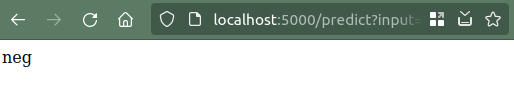